# Test for titanic dataset

## Import lib

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# ONNX
import onnxruntime as rt
import onnx
from onnx import ModelProto
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

# Plot graph
import pydot
from IPython.display import Image

## Import data

In [3]:
df_train = pd.read_csv('data/train.zip', compression='zip')

---

# Test mean-std transformation: on `Age` columns

---

In [4]:
age_raw = df_train['Age'].values.reshape(-1,1)

---

## Replace missing values

### Train imputer (fillna)

In [5]:
imp = SimpleImputer(missing_values=np.nan, strategy="median")
imp.fit(age_raw)
age_completed = imp.transform(age_raw)

print(100*"-")
print("Imputer option")
print(imp.get_params())
print(100*"-")
print("Replace value")
print(imp.transform([[np.nan]])[0,0])

----------------------------------------------------------------------------------------------------
Imputer option
{'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'median', 'verbose': 0}
----------------------------------------------------------------------------------------------------
Replace value
28.0


### Check effect of imputation (fillna)

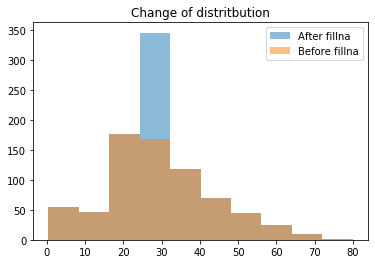

In [6]:
plt.figure()

plt.hist(age_completed, alpha=0.5, label='After fillna')
plt.hist(age_raw[~np.isnan(age_raw)], alpha=0.5, label='Before fillna')

plt.title("Change of distritbution")
plt.legend()
plt.show()

### Save to onnx

In [7]:
initial_type = [('float_input', FloatTensorType([1, 1]))]
onx = convert_sklearn(imp, initial_types=initial_type)

onnx_file = "imputer_fillna.onnx"

with open(onnx_file, "wb") as f:
    f.write(onx.SerializeToString())

The maximum opset needed by this model is only 1.


### Predict using ONNX

In [8]:
sess = rt.InferenceSession(onnx_file)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
age_completed_onnx = sess.run([label_name], {input_name: age_raw.astype(np.float32)})[0]

### Compare diff

In [9]:
is_float_diff_zero = all(np.isclose(age_completed_onnx.reshape(1,-1)[0],
                                    age_completed.reshape(1,-1)[0]))

if is_float_diff_zero:
    print("All values match")
else:
    print("Onxx prediction does not match standard sklearn prediction.")

All values match


### View graph of transformation

see `01-iris/01-iris_web_tuto.ipynb` for detailed version

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.1"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "float_input"
    output: "variable"
    name: "Imputer"
    op_type: "Imputer"
    attribute {
      name: "imputed_value_floats"
      floats: 28.0
      type: FLOATS
    }
    attribute {
      name: "replaced_value_float"
      f: nan
      type: FLOAT
    }
    domain: "ai.onnx.ml"
  }
  name: "4d5a1f54e3df484f97ac8f86afa3b046"
  input {
    name: "float_input"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            dim_value: 1
          }
        }
      }
    }
  }
  output {
    name: "variable"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            dim_value: 1
          }
        }
      }
    }
  }
}
opset_import {
  domain: "ai.onnx.ml"
  version: 

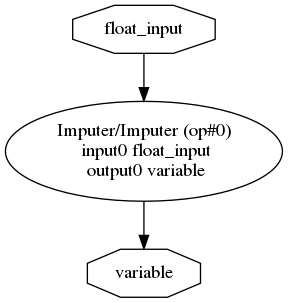

In [10]:
# Load
onnx_model = onnx.load(onnx_file)
model = ModelProto()
with open(onnx_file, 'rb') as fid:
    content = fid.read()
    model.ParseFromString(content)
    
# Make pydot object
pydot_graph = GetPydotGraph(model.graph, name=model.graph.name, rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring"))
graph_file = 'imp_graph.dot'
graph_img = 'imp_graph.png'
pydot_graph.write(graph_file)

# Write image
(graph,) = pydot.graph_from_dot_file(graph_file)
graph.write_png(graph_img)

# View transformation
# # JSON-like
print(onnx_model.__str__())

# # Image
Image(graph_img)

---

## Rescale data to have mean 0 and std 1

### Train scale transformer (fillna)

In [11]:
scaler = StandardScaler().fit(age_completed)
age_scaled = scaler.transform(age_completed)

print(100*"-")
print("Scaler option")
print(scaler.get_params())
print(100*"-")
print("Mean")
print(scaler.mean_[0])
print(100*"-")
print("Scale (STD)")
print(scaler.scale_[0])

----------------------------------------------------------------------------------------------------
Scaler option
{'copy': True, 'with_mean': True, 'with_std': True}
----------------------------------------------------------------------------------------------------
Mean
29.36158249158249
----------------------------------------------------------------------------------------------------
Scale (STD)
13.012388272793666


### Check transformation

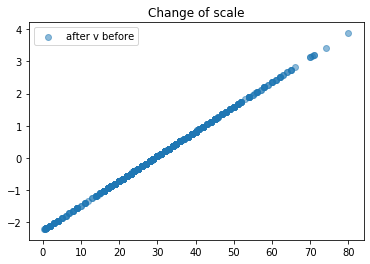

In [12]:
plt.figure()
plt.scatter(age_completed, age_scaled, alpha=0.5, label='after v before')
plt.title("Change of scale")
plt.legend()
plt.show()

### Save to onnx

In [13]:
initial_type = [('float_input', FloatTensorType([1, 1]))]
onx = convert_sklearn(scaler, initial_types=initial_type)

onnx_file = "scaler_transformation.onnx"

with open(onnx_file, "wb") as f:
    f.write(onx.SerializeToString())

The maximum opset needed by this model is only 1.


### Predict using ONNX

In [14]:
sess = rt.InferenceSession(onnx_file)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
age_scaled_onnx = sess.run([label_name], {input_name: age_completed.astype(np.float32)})[0]

### Compare diff

In [15]:
is_float_diff_zero = all(np.isclose(age_scaled_onnx.reshape(1,-1)[0],
                                    age_scaled.reshape(1,-1)[0]))

if is_float_diff_zero:
    print("All values match")
else:
    print("Onxx prediction does not match standard sklearn prediction.")
    
    plt.figure()
    plt.scatter(age_scaled_onnx, age_scaled, alpha=0.5, label='onnx v direct')
    plt.title("Difference in re-scale")
    plt.legend()
    plt.show()

All values match


### View graph of transformation

see `01-iris/01-iris_web_tuto.ipynb` for detailed version

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.1"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "float_input"
    output: "variable"
    name: "Scaler"
    op_type: "Scaler"
    attribute {
      name: "offset"
      floats: 29.361581802368164
      type: FLOATS
    }
    attribute {
      name: "scale"
      floats: 0.07684984058141708
      type: FLOATS
    }
    domain: "ai.onnx.ml"
  }
  name: "d65d3f3f055b409797094497ef3e2354"
  input {
    name: "float_input"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            dim_value: 1
          }
        }
      }
    }
  }
  output {
    name: "variable"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            dim_value: 1
          }
        }
      }
    }
  }
}
opset_import {
  domain: "ai.onnx.ml"
  vers

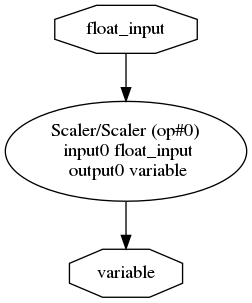

In [16]:
# Load
onnx_model = onnx.load(onnx_file)
model = ModelProto()
with open(onnx_file, 'rb') as fid:
    content = fid.read()
    model.ParseFromString(content)
    
# Make pydot object
pydot_graph = GetPydotGraph(model.graph, name=model.graph.name, rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring"))
graph_file = 'scaler_graph.dot'
graph_img = 'scaler_graph.png'
pydot_graph.write(graph_file)

# Write image
(graph,) = pydot.graph_from_dot_file(graph_file)
graph.write_png(graph_img)

# View transformation
# # JSON-like
print(onnx_model.__str__())

# # Image
Image(graph_img)

---

## Test sklearn pipeline

### Train fillna-scaler pipeline

In [17]:
pipe_1 = make_pipeline(imp, scaler)
age_pipe_1 = pipe_1.transform(age_raw)

### Check results

In [18]:
is_float_diff_zero = all(np.isclose(age_pipe_1.reshape(1,-1)[0],
                                    age_scaled.reshape(1,-1)[0]))

if is_float_diff_zero:
    print("All values match")
else:
    print("Pipe_1 does not match step by step prediction.")

    plt.figure()
    plt.scatter(age_pipe_1, age_scaled, alpha=0.5, label='after v before')
    plt.title("Pipe v step by step")
    plt.legend()
    plt.show()

All values match


### Save to onnx

In [19]:
initial_type = [('float_input', FloatTensorType([1, 1]))]
onx = convert_sklearn(pipe_1, initial_types=initial_type)

onnx_file = "pipe_1.onnx"

with open(onnx_file, "wb") as f:
    f.write(onx.SerializeToString())

The maximum opset needed by this model is only 1.


### Predict using ONNX

In [20]:
sess = rt.InferenceSession(onnx_file)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
age_pipe_1_onnx = sess.run([label_name], {input_name: age_raw.astype(np.float32)})[0]

### Compare diff

In [21]:
is_float_diff_zero = all(np.isclose(age_pipe_1_onnx.reshape(1,-1)[0],
                                    age_pipe_1.reshape(1,-1)[0]))

if is_float_diff_zero:
    print("All values match")
else:
    print("Onxx prediction does not match standard sklearn prediction.")
    
    plt.figure()
    plt.scatter(age_scaled_onnx, age_scaled, alpha=0.5, label='onnx v direct')
    plt.title("Difference in re-scale")
    plt.legend()
    plt.show()

All values match


#### View graph of transformation

see `01-iris/01-iris_web_tuto.ipynb` for detailed version

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.1"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "float_input"
    output: "variable"
    name: "Imputer"
    op_type: "Imputer"
    attribute {
      name: "imputed_value_floats"
      floats: 28.0
      type: FLOATS
    }
    attribute {
      name: "replaced_value_float"
      f: nan
      type: FLOAT
    }
    domain: "ai.onnx.ml"
  }
  node {
    input: "variable"
    output: "variable1"
    name: "Scaler"
    op_type: "Scaler"
    attribute {
      name: "offset"
      floats: 29.361581802368164
      type: FLOATS
    }
    attribute {
      name: "scale"
      floats: 0.07684984058141708
      type: FLOATS
    }
    domain: "ai.onnx.ml"
  }
  name: "7988d03f2cd24e1e8b72f70c7ef66462"
  input {
    name: "float_input"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 1
          }
          dim {
            dim_value: 1
          

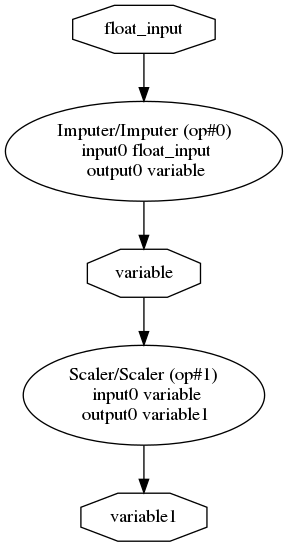

In [22]:
# Load
onnx_model = onnx.load(onnx_file)
model = ModelProto()
with open(onnx_file, 'rb') as fid:
    content = fid.read()
    model.ParseFromString(content)
    
# Make pydot object
pydot_graph = GetPydotGraph(model.graph, name=model.graph.name, rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring"))
graph_file = 'pipe_1_graph.dot'
graph_img = 'pipe_1_graph.png'
pydot_graph.write(graph_file)

# Write image
(graph,) = pydot.graph_from_dot_file(graph_file)
graph.write_png(graph_img)

# View transformation
# # JSON-like
print(onnx_model.__str__())

# # Image
Image(graph_img)

## Test the custom class: `type_converter.py`

**Custom class are not supported by onnx:**

```python
MissingShapeCalculator: Unable to find a shape calculator for type '<class 'type_converter.TypeConverter'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library (ie: onnxmltools), you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.
```

### Train custom type conveter

In [23]:
from type_converter import TypeConverter
chosen_type = 'number'

type_conv = TypeConverter(detected_type=chosen_type)
type_conv.fit([])
age_converted = type_conv.transform(age_raw.astype(int).reshape(1,-1)[0])

print(age_converted[:10])

[ 2.20000000e+01  3.80000000e+01  2.60000000e+01  3.50000000e+01
  3.50000000e+01 -9.22337204e+18  5.40000000e+01  2.00000000e+00
  2.70000000e+01  1.40000000e+01]


### Try to export to onnx

In [24]:
initial_type = [('int', FloatTensorType([1]))]
onx = convert_sklearn(type_conv, initial_types=initial_type)

onnx_file = "type_converter.onnx"

with open(onnx_file, "wb") as f:
    f.write(onx.SerializeToString())

MissingShapeCalculator: Unable to find a shape calculator for type '<class 'type_converter.TypeConverter'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library (ie: onnxmltools), you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.


# End of script